<a href="https://www.kaggle.com/code/averma111/pytorch-ps3e15?scriptVersionId=129832890" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
%%capture 
!pip install optuna

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
from tqdm.notebook import tqdm
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

In [26]:
def get_dataframe(path):
    df=pd.read_csv(path)
    return df.set_index(df.iloc[:,0])

In [27]:
data = get_dataframe('/kaggle/input/playground-series-s3e15/data.csv')
original = get_dataframe('/kaggle/input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv')

In [28]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    summ['duplicate'] = df.duplicated().sum()
    return summ

In [29]:
summary('data',data)

data shape: (31644, 10)


,dtypes,null,unique,min,median,max,mean,std,duplicate
id,int64,0,31644,0.0000,15821.5000,31643.000,15821.500000,9134.980296,0
author,object,5024,10,NaN,NaN,NaN,NaN,NaN,0
geometry,object,5500,3,NaN,NaN,NaN,NaN,NaN,0
pressure [MPa],float64,4452,144,0.1000,11.0700,20.680,10.640747,4.333683,0
mass_flux [kg/m2-s],float64,4791,733,0.0000,2731.0000,7975.000,3068.011023,1777.032080,0
x_e_out [-],float64,10415,1682,-0.8667,0.0038,0.232,-0.000453,0.100911,0
D_e [mm],float64,5488,43,1.0000,7.8000,37.500,8.629255,5.185692,0
D_h [mm],float64,4589,49,1.0000,10.0000,120.000,14.174330,19.838489,0
length [mm],float64,4759,70,10.0000,610.0000,3048.000,832.987391,672.299239,0
chf_exp [MW/m2],float64,0,109,0.8000,3.4000,19.300,3.796985,1.983991,0


In [30]:
summary('original',original)

original shape: (1865, 10)


,dtypes,null,unique,min,median,max,mean,std,duplicate
id,int64,0,1865,1,933.0000,1865,933.000000,538.523444,0
author,object,0,10,Beus,NaN,Williams,NaN,NaN,0
geometry,object,0,3,annulus,NaN,tube,NaN,NaN,0
pressure [MPa],float64,0,114,0.1,10.3400,20.68,10.010949,4.282715,0
mass_flux [kg/m2-s],int64,0,578,0,2590.0000,7975,2862.647721,1656.412247,0
x_e_out [-],float64,0,1360,-0.8667,0.0244,0.232,0.016179,0.117575,0
D_e [mm],float64,0,36,1.0,8.5000,37.5,9.417212,6.333807,0
D_h [mm],float64,0,41,1.0,10.3000,120.0,16.167721,21.182870,0
length [mm],int64,0,54,10,625.0000,3048,911.340483,726.718974,0
chf_exp [MW/m2],float64,0,109,0.8,3.5000,19.3,3.854638,1.985535,0


<AxesSubplot: xlabel='x_e_out [-]', ylabel='Count'>

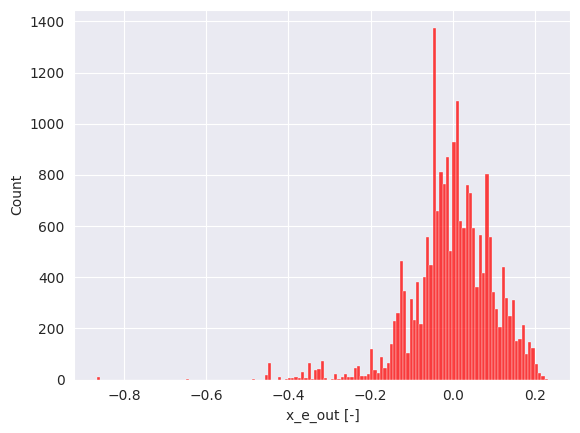

In [35]:
sns.histplot(data,x='x_e_out [-]',color='r')

<AxesSubplot: xlabel='x_e_out [-]', ylabel='Count'>

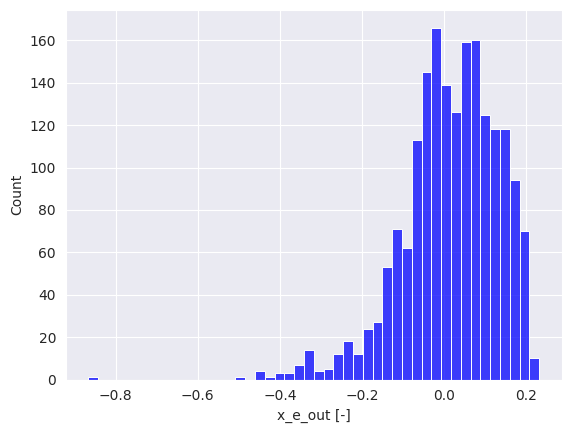

In [37]:
sns.histplot(original,x='x_e_out [-]',color='b')

In [41]:
def numerical_features(df):
    numerical_feature = df.select_dtypes(include=['float64'])
    return numerical_feature

numerical_features = numerical_features(data)

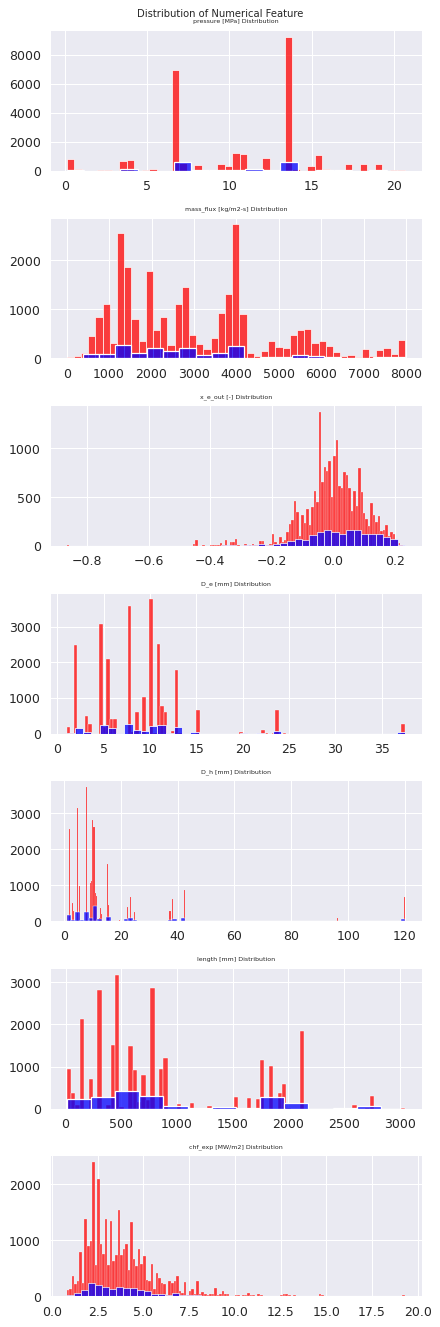

In [52]:
def plot_numerical_histogram():
    fig, ax = plt.subplots(7, 1, figsize = (5, 15), dpi = 90)
    ax = ax.flatten()

    for i, column in enumerate(numerical_features):
        sns.histplot(data[column], ax=ax[i], color='r')
        sns.histplot(original[column], ax=ax[i], color='b')
    
        ax[i].set_title(f'{column} Distribution', size = 5)
        ax[i].set_xlabel(None)
        ax[i].set_ylabel(None)
    
    fig.suptitle('Distribution of Numerical Feature', fontsize = 8)
    plt.tight_layout()
    
plot_numerical_histogram()

In [101]:
def plot_categorical_data(df,column_name,palette,dataset_name):
    fig, ax = plt.subplots(1, 1, figsize = (12, 4))
    #ax = ax.flatten()
    sns.countplot(data = df, y = column_name, ax = ax, palette = palette, 
                  order = data[column_name].value_counts().index)
    ax.yaxis.label.set_size(20)
    plt.yticks(fontsize = 12)
    ax.set_xlabel('Count', fontsize = 20)
    ax.set_ylabel(None)
    plt.xticks(fontsize = 12)

    fig.suptitle(f'{column_name.title()} in {dataset_name} Dataset', fontsize = 15, fontweight = 'bold')
    plt.tight_layout()

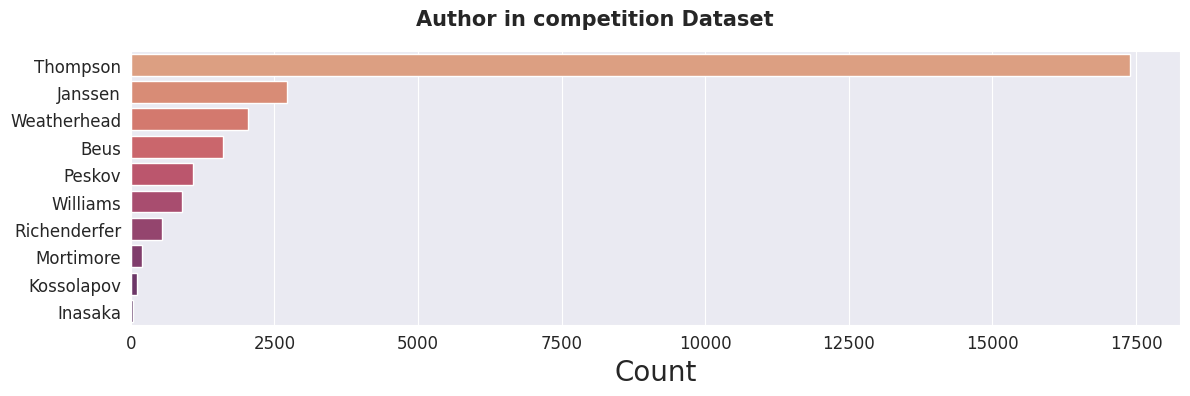

In [102]:
plot_categorical_data(data,'author','flare','competition')

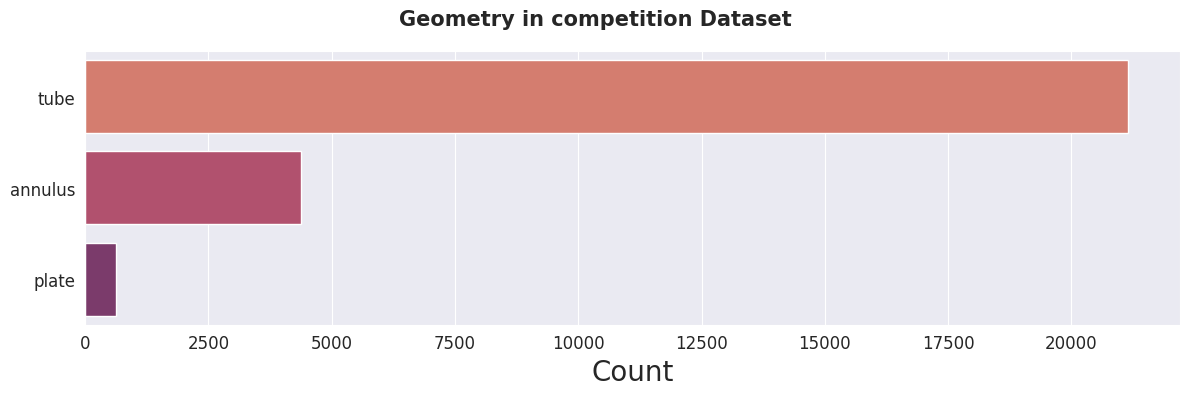

In [103]:
plot_categorical_data(data,'geometry','flare','competition')

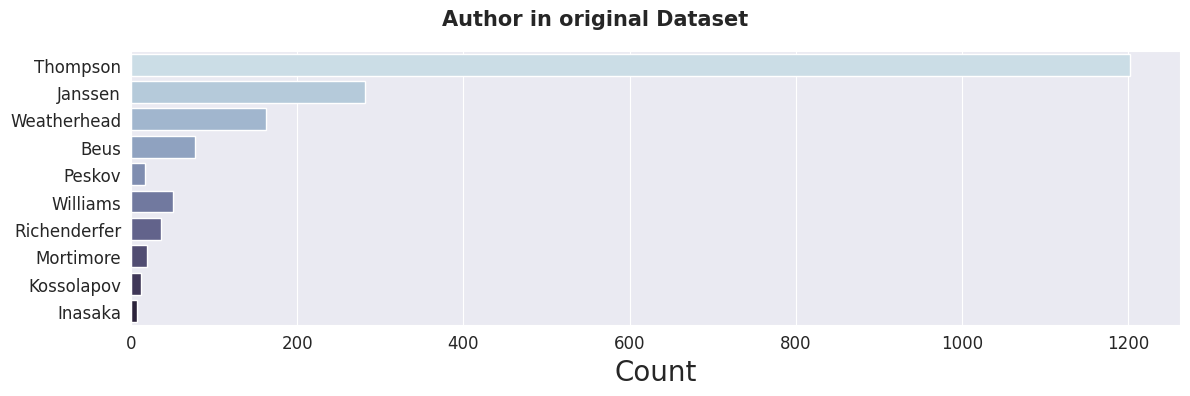

In [104]:
plot_categorical_data(original,'author','ch:s=.25,rot=-.25','original')

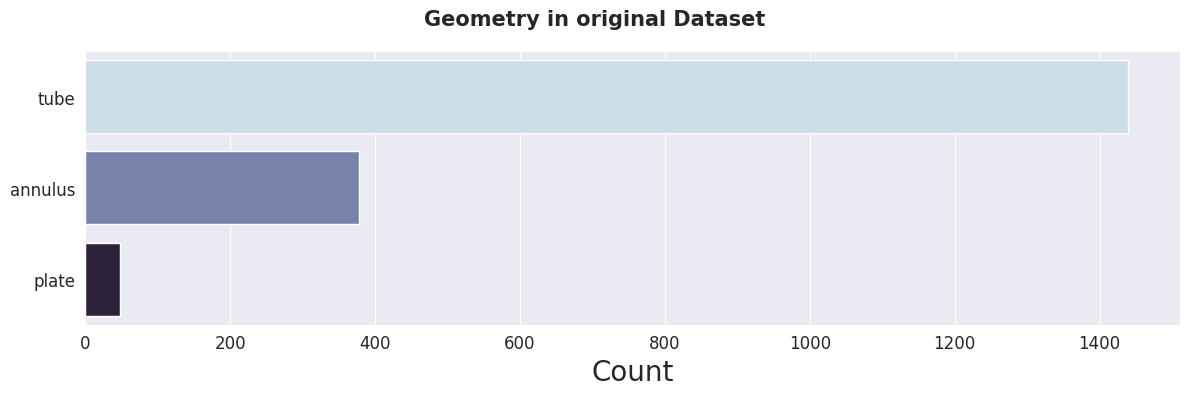

In [105]:
plot_categorical_data(original,'geometry','ch:s=.25,rot=-.25','original')

In [109]:
def show_correlation(dataset, column_name,cmap):
    corr = dataset.corr(method = 'kendall')
    plt.figure(figsize = (10, 10), dpi = 300)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, cmap = cmap, annot = True, annot_kws = {'size' : 12})
    plt.title(f'{column_name.tittle()} Dataset Correlation Matrix\n', fontsize = 15, weight = 'bold')
    plt.show()

In [111]:
show_correlation(data[numerical_features],'flare')

ValueError: Boolean array expected for the condition, not object